# Instruction Tuning the Model

### Download Instruction Dataset

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


Let's print one of the entries

In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


##### TODO: Exercise 7.1 Changing prompt styles
After fine-tuning the model with the Alpaca prompt style, try the Phi-3 prompt style
shown in figure 7.4 and observe whether it affects the response quality of the model

##### Implementing the prompt formatting function

In [3]:
def format_input(entry):
    instruction = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction + input


def format_output(entry):
    return f"\n\n### Response:\n{entry['output']}"

Let's thest the new function prompt formatting function on a dataset entry, and confirm its output is correct.

In [4]:
test_data = data[50]
print(format_input(test_data) + format_output(test_data))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


Let's thest the new function prompt formatting function on an entry that's missin the input field, and confirm it output is correct.

In [5]:
test_data = data[2]
print(format_input(test_data) + format_output(test_data))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 45 kilometers to meters.

### Response:
45 kilometers is 45000 meters.


##### Partitioning the dataset

In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion :]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Organize Data into Training Batches

Efficiently padding the data samples to equal lenghts in order to assemble multiple instruction examples in a batch.


1. **Format data using prompt template**.
2. **Tokenize formatted data**.
3. **Adjust inputs to same lenght** with padding tokens.
4. **Create target token IDs**, by shifting the inputs by 1.
5. **Replace padding tokens with placeholders**, to exclude them from training loss.

##### Define Instruction Dataset
That applies formatting and pretokenizes all inputs in the dataset.

In [7]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        for entry in data:
            formatted_input = format_input(entry)
            formatted_output = format_output(entry)
            full_text = formatted_input + formatted_output
            encoded_text = tokenizer.encode(full_text)

            self.encoded_texts.append(encoded_text)

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

##### Tokenization

Similar to the pre-training and classification fine-tuning, we use gpt tokenizer to encode the data, allowing for a special `eot` character

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


##### Adjust inputs to the same lenght
Define a collate function that adjusts inputs to the same lenght.

A final version of the collate function will be used later on in the Dataloader to collate inputs into batches of the same size.

In [9]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

Let's test it out:

In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


As expected, the input with the longest length has no padding, whereas the other two inputs are padded to match the length of the first input.

##### Create Targets

Let's update the collate function so we also compute the target tensors.

The target tensors are the same as the input ones, shifted by one position.

In [11]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [12]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (inputs_1, inputs_2, inputs_3)
print(f"Inputs:\n : {custom_collate_draft_2(batch)[0]}")
print(f"Targets:\n : {custom_collate_draft_2(batch)[1]}")

Inputs:
 : tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
 : tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


##### Replace padding tokens with placeholders

This allows us to exclude all padding tokens from contributing to the loss calculation.

- The default setting of the cross entropy function in PyTorch is cross_entropy(..., ignore_index=-100). This means that it ignores targets labeled with -100.
- Retaining the `eot` token allows the LLM to learn when to generate an end- of-text token in response to instructions, which we use as an indicator that the generated response is complete

In [13]:
def custom_collate_fn(
    batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"
):
    max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # Replace extra padding tokens in targets by `ignore_index`.
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

Let's test it now. 

We expect to see targets to have at most one padding token, and ignore tokens (-100) afterwards.

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (inputs_1, inputs_2, inputs_3)
print(f"Inputs:\n : {custom_collate_fn(batch)[0]}")
print(f"Targets:\n : {custom_collate_fn(batch)[1]}")

Inputs:
 : tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
 : tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


It works as expected !

##### Exercise 7.2 Instruction and input masking
After completing the chapter and fine-tuning the model with InstructionDataset,
replace the instruction and input tokens with the -100 mask to use the instruction
masking method illustrated in figure 7.13. Then evaluate whether this has a positive
effect on model performance.

### Creating data loaders for an instruction dataset

##### Set up device in Collate function.

Moving the data into the device as part of the colalte function allows transfering the data outside of the training loop, preventing it from blocking the accelerator (GPU, TPU) during model training.

In [15]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    return device


device = get_device()
print("Device:", device)

Device: mps


We override the colalte function to set up the device and `max_length` to match the GPT2 max context length.

In [16]:
from functools import partial

custom_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

##### Create Data Loaders

In [17]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

Let's examine the size of the loader. 

We expect to see batches with different lengths.

In [18]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

### Loading Pre-trained Model

In [19]:
# Load GPT model
%run gpt-model.ipynb
%run data-processing.ipynb
del model

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
 Jiang exclude intensimet
 B LeavingACC Deng
Mean:
  tensor([-0.3596, -0.2606])
Variance :
  tensor([0.2015, 0.2673])
Norm. Mean:
  tensor([    -0.0000,      0.0000], grad_fn=<MeanBackward1>)
Norm. Variance :
  tensor([1.0000, 1.0000], grad_fn=<VarBackward0>)
tensor([[0.2685, 0.7413],
        [0.2738, 0.7564],
        [0.2668, 0.7366],
        [0.2618, 0.7218],
        [0.2712, 0.7495]], grad_fn=<MmBackward0>)
tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V2 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V1 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.

Config definitions

In [20]:
BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_layers": 12,
        "n_heads": 12,
        "file_name": "gpt2-small-124M.pth",
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_layers": 24,
        "n_heads": 16,
        "file_name": "gpt2-medium-355M.pth",
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_layers": 36,
        "n_heads": 20,
        "file_name": "gpt2-large-774M.pth",
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,
        "n_layers": 48,
        "n_heads": 25,
        "file_name": "gpt2-xl-1558M.pth",
    },
}

Loading the model.

We load Medium-355M instead of the Small-124M as the smallest models don't have enough capacity to learn to be instruction-tuned properly.

TODO: Test this hypothesis.

In [21]:
model_name = "gpt2-medium (355M)"
file_name = model_configs[model_name]["file_name"]
BASE_CONFIG.update(model_configs[model_name])

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device(get_device())
gpt.to(device)
print(device)

mps


##### Testing the Model before tuning it.

In [22]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    return torch.tensor(encoded).unsqueeze(0)


def token_ids_to_text(tokens, tokenizer):
    formatted = tokens.squeeze(0).tolist()
    return tokenizer.decode(formatted)

In [23]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [24]:
token_ids = generateText(
    model=gpt,
    idx=text_to_token_ids(input_text, tokenizer).to(
        device
    ),  # Ensure input is on the correct device
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [25]:
response_text = generated_text[len(input_text) :].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [38]:
# For a given batch, compute the cross entropy.
def calc_loss_batch(
    input_batch: torch.Tensor,
    target_batch: torch.Tensor,
    model: torch.nn.Module,
    device,
):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    # Run model.
    logits = model(input_batch)
    # Compute cross-entropy loss.
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


# Calculate the loss for a given data_loader.
def calc_loss_loader(data_loader, model, device, num_batches=torch.inf):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Iterate through batches and compute sum loss.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i > num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    # Return avg. loss.
    return total_loss / num_batches


# Evaluate the model on the train and validation loaders. Runs only on the `eval_iter` number of batches.
# Returns the train and validation losses.
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


# Generates text.
def generate_and_print_sample(
    model,
    tokenizer,
    device,
    start_context,
    temperature: int = 0.0,
    top_k=None,
    eos_id=None,
):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generateText(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            temperature=temperature,
            top_k=top_k,
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


# Trains the model.
# Returns the train, validation losses, and a list of all the tokens seen during training.
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    def print_evals():
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(
            f"Ep {epoch+1} (Step {global_step:06d}): "
            f"Train loss {train_loss:.3f}, "
            f"Val loss {val_loss:.3f}"
        )

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Print evals.
            if global_step % eval_freq == 0:
                print_evals()

        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [43]:
gpt.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.619566631317139
Validation loss: 4.510749673843383


### Instruction Fine Tuning the LLMs

In [ ]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.168, Val loss 3.156
Ep 1 (Step 000005): Train loss 1.309, Val loss 1.337
Ep 1 (Step 000010): Train loss 1.081, Val loss 1.127
Ep 1 (Step 000015): Train loss 0.986, Val loss 1.061
Ep 1 (Step 000020): Train loss 0.928, Val loss 1.039
Ep 1 (Step 000025): Train loss 0.902, Val loss 1.031
Ep 1 (Step 000030): Train loss 0.895, Val loss 0.956
Ep 1 (Step 000035): Train loss 0.896, Val loss 0.959
Ep 1 (Step 000040): Train loss 0.771, Val loss 0.933
Ep 1 (Step 000045): Train loss 0.921, Val loss 0.900
Ep 1 (Step 000050): Train loss 0.817, Val loss 0.899
Ep 1 (Step 000055): Train loss 0.699, Val loss 0.898
Ep 1 (Step 000060): Train loss 0.776, Val loss 0.883
Ep 1 (Step 000065): Train loss 0.816, Val loss 0.872
Ep 1 (Step 000070): Train loss 0.674, Val loss 0.856
Ep 1 (Step 000075): Train loss 0.704, Val loss 0.880
Ep 1 (Step 000080): Train loss 0.795, Val loss 0.869
Ep 1 (Step 000085): Train loss 0.684, Val loss 0.853
Ep 1 (Step 000090): Train loss 0.627, Val loss

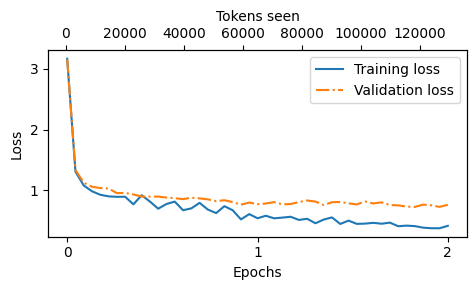

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def _to_list(x):
    if torch.is_tensor(x):
        # avoids .numpy() so no NumPy dependency
        return x.detach().cpu().tolist()
    # handle lists/tuples already
    return x


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

##### TODO: Exercise 7.3 Fine-tuning on the original Alpaca dataset
The Alpaca dataset, by researchers at Stanford, is one of the earliest and most pop-
ular openly shared instruction datasets, consisting of 52,002 entries. As an alterna-
tive to the instruction-data.json file we use here, consider fine-tuning an LLM on
this dataset. The dataset is available at https://mng.bz/NBnE.
This dataset contains 52,002 entries, which is approximately 50 times more than
those we used here, and most entries are longer. Thus, I highly recommend using a
GPU to conduct the training, which will accelerate the fine-tuning process. If you
encounter out-of-memory errors, consider reducing the batch_size from 8 to 4, 2,
or even 1. Lowering the allowed_max_length from 1,024 to 512 or 256 can also
help manage memory problems.

#### Extracting and saving responses

In [54]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generateText(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text) :].replace("### Response:", "").strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of storm that typically produces a strong wind and/or rain.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author 